# Extrinsic camera calibration for DiDi round 2

In [1]:
import rosbag, rospy
from sensor_msgs.msg import Image, CameraInfo
from image_geometry import PinholeCameraModel
import tf

import cv2
from cv_bridge import CvBridge, CvBridgeError

import os
import json, yaml
import glob, random, math
from scipy.optimize import minimize

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# BGR to RGB conversion for opencv to matplotlib format
def BGR2RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### Explore rosbag 
In the first terminal, run :

```
rosbag play -l -r 5 2017-04-19-15-38-28.bag
```
`-l` option plays the bag in loop,   
`-r 5` option speeds up the video 5 times.

In the second terminal, type 
```
rostopic list
```

Here is the way to get same info in python. Following is the list of topics in the calibration rosbag :

In [3]:
filename = '/media/prerit/Data/didi_data/ped/ped_005/005.bag'
bag = rosbag.Bag(filename)
info = bag.get_type_and_topic_info()
info.topics.keys()

['/radar/tracks',
 '/vehicle/steering_report',
 '/tf',
 '/vehicle/brake_report',
 '/linear_velocity_viz',
 '/estimated_vel',
 '/vehicle/twist',
 '/vehicle/wheel_speed_report',
 '/estimate_twist',
 '/vehicle/gps/time',
 '/velodyne_nodelet_manager/bond',
 '/vehicle/gps/vel',
 '/vehicle/gps/fix',
 '/vehicle/suspension_report',
 '/velodyne_packets',
 '/vehicle/sonar_cloud',
 '/estimated_vel_mps',
 '/vehicle/surround_report',
 '/diagnostics',
 '/vehicle/brake_info_report',
 '/vehicle/imu/data_raw',
 '/vehicle/gear_report',
 '/radar/range',
 '/vehicle/throttle_report',
 '/image_raw',
 '/vehicle/fuel_level_report',
 '/rosout',
 '/estimated_vel_kmph',
 '/vehicle/filtered_accel',
 '/rosout_agg',
 '/obstacle/ped/pose',
 '/vehicle/joint_states',
 '/vehicle/twist_controller/parameter_descriptions',
 '/can_bus_dbw/can_rx',
 '/vehicle/twist_controller/parameter_updates',
 '/vehicle/throttle_info_report',
 '/current_pose',
 '/current_velocity',
 '/vehicle/misc_1_report',
 '/radar/points',
 '/vehicle/

### Load camera intrinsic calibration data

Almost all ROS packages for projection transformations require 'CameraInfo' topic. Unfortunately, this topic is missing in the rosbag, instead we are provided with yaml file. We will use this yaml file to load the calibration data into 'CameraInfo' :

In [4]:
K = np.matrix([[  1.35103293e+03,   0.00000000e+00,   6.11621068e+02],
       [  0.00000000e+00,   1.36150275e+03,   5.69319474e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
D = np.array([-0.1454428 ,  0.22506983,  0.00353645, -0.00618987, -0.05673468])

def load_cam_info():
    with open('ost.yaml','r') as cam_calib_file :
        cam_calib = yaml.load(cam_calib_file)
        cam_info = CameraInfo()
        cam_info.height = cam_calib['image_height']
        cam_info.width = cam_calib['image_width']
        cam_info.K = cam_calib['camera_matrix']['data']
        cam_info.D = cam_calib['distortion_coefficients']['data']
        cam_info.R = cam_calib['rectification_matrix']['data']
        cam_info.P = cam_calib['projection_matrix']['data']
        cam_info.distortion_model = cam_calib['distortion_model']
        return cam_info
    
cameraModel = PinholeCameraModel()
cam_info = load_cam_info()
cameraModel.fromCameraInfo(cam_info)
P0 = cameraModel.P
cameraModel.K = K
cameraModel.D = np.matrix(D).T

### Extract frames from rosbag

I have selected 3 frames for calibration. 
Assuming rosbag is playing, run rviz in another terminal:
```
rosrun rviz rviz
```
After changing the system frame to velodyne, point cloud should be visible. By pausing rosbag as required (make sure to note the time), individual frames can be analyzed. Using selection tool, individual points of interest can be selected. The coordinates of the points are noted in `calib.json`. Below I have extracted images for the corresponding frames. The camera pixels for the points of interest are also recorded in `calib.json`. 

In [5]:
with open('calib.json', 'r') as calib_file :
    calib_data = json.load(calib_file)
save_dir = 'images/'  
bridge = CvBridge()
img_index = 0
frame_list = []
    
data_dir = '/media/prerit/Data/didi_data'
for bag in calib_data :
    filename = os.path.join(data_dir, bag['dir'], bag['dir']+'_'+bag['bag'], bag['bag']+'.bag')
    data = bag['data']
    frame_list += data
    n_frames = len(data)
    # time frames to use for calibration
    frames = [data[i]['timestamp'] for i in range(n_frames)]
    
    # save calibration images
    for t in frames :
        with rosbag.Bag(filename, 'r') as bag:
            start_time = rospy.Time.from_sec(t)
            for topic, msg, t in bag.read_messages(start_time=start_time, topics='/image_raw'):
                if topic == "/image_raw" :
                    try :
                        cv_image = bridge.imgmsg_to_cv2(msg, "bgr8")
                    except CvBridgeError, e:
                        print e
                    img_index += 1
                    image_name = save_dir+str(img_index).zfill(2)+".jpg"
                    cv2.imwrite(image_name, cv_image)    
                    break

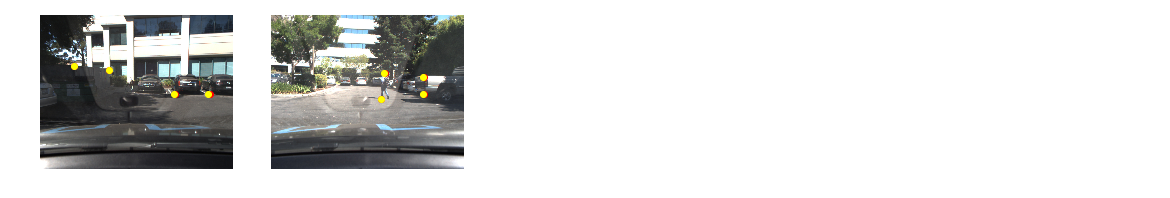

In [6]:
images = sorted(glob.glob('images/*'))
ncol = 5
nrow = int(math.ceil(1.*len(images)/ncol))
fig, axes = plt.subplots(nrow, ncol, figsize=(20,3*nrow))
for ax in axes.flatten():
    ax.axis('off')

for frame, img_file, ax in zip(frame_list, images, axes.flatten()) :
    img = cv2.imread(img_file)
    #rect_img = np.copy(img)
    rect_img = cv2.undistort(img, K, D, None, K)
    rect_img = BGR2RGB(rect_img)
    ax.imshow(rect_img)
    pts = np.array(frame['camera'])
    pts_array = np.array([[[pt[0], pt[1]]] for pt in pts]).astype(np.float32)
    rect_pts = cv2.undistortPoints(pts_array, K, D, P=K) 
    #rect_pts = pts
    ax.scatter(rect_pts.T[0], rect_pts.T[1], c='red')
    ax.scatter(pts.T[0], rect_pts.T[1], c='yellow')

## Lidar-camera calibration 

To speed up optimization, we can start with an initial guess for lidar-camera calibration since lidar-camera offset is already provided. Firstly, we need to account for different frame conventions for lidar and camera. 

| Lidar  |  Camera |
| :-----:|:-------:|
|   +x   |   +z    |
|   -y   |   +x    |
|   -z   |   +y    |

Additionally, there is a translation offset already provided.

In [7]:
R0 = np.array([[ 0,-1, 0, 0],
               [ 0, 0,-1, 0],
               [ 1, 0, 0, 0],
               [ 0, 0, 0, 1]], dtype=np.float32)
cam_base = np.array([1.9304, 0, 0.9398])
lidar_base = np.array([1.5494, 0, 1.27])
offset = lidar_base - cam_base
R0[:,3] = np.array([-offset[1],-offset[2],offset[0],1]) 
print('Lidar-camera calibration matrix estimate :')
print(R0)

Lidar-camera calibration matrix estimate :
[[ 0.         -1.          0.         -0.        ]
 [ 0.          0.         -1.         -0.33019999]
 [ 1.          0.          0.         -0.38100001]
 [ 0.          0.          0.          1.        ]]


### Projection without calibration

Next we estimate the projection using the information already available.

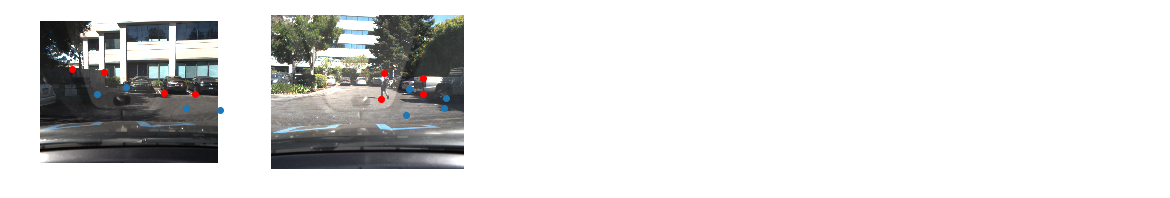

In [8]:
fig, axes = plt.subplots(nrow, ncol, figsize=(20,3*nrow))
for ax in axes.flatten():
    ax.axis('off')
R = K.I * P0 * R0
cameraModel.P = K*R
#K = cameraModel.K
#cameraModel.D = np.matrix([-0.09985114,  0.02541636,  0.00453623,  0.0016495 ,  0.04775354]).T

for frame, img_file, ax in zip(frame_list, images, axes.flatten()) :
    img = cv2.imread(img_file)
    img = BGR2RGB(img)
    ax.imshow(img)
    pts = np.array(frame['camera'])
    ax.scatter(pts.T[0], pts.T[1], c='red')
    pts_pred = []
    for pt_cloud, pt_cam in zip(frame['cloud'],frame['camera']) :
        #rotated_pt = R0.dot(pt_cloud+[1])
        pts_pred.append(cameraModel.project3dToPixel(pt_cloud+[1]))
    pts_pred = np.array(pts_pred)
    ax.scatter(pts_pred.T[0], pts_pred.T[1])

This is already pretty good given no calibration was used. It serves as a good initial estimate.

### Calibration

Next, we perform the calibration using calibration ros bag. We include the R0 matrix calculated above as an initial transformation.

There are 6 parameters for lidar-camera calibration :
* 3 translation parameters : tx, ty, tz
* 3 rotation angles (Euler angles) : yaw, pitch, roll

Out goal is to find these parameters using calibration data. The 6 parameters are initialized to random numbers in a reasonable range and the camera pixels are predicted using lidar points and applying translation and rotation matrix constructed using these 6 parameters. The goal is to minimize the error (cost function) between actual camera pixel coordinates and the predicted coordinates.

In [9]:
def costFunc(x) :
    tx, ty, tz, yaw, pitch, roll = x
    T = [tx, ty, tz, 1]
    R = tf.transformations.euler_matrix(roll, pitch, yaw)
    R[:, 3] = T
    Rt = K.I * P0 * R * R0
    cameraModel.P = K * Rt

    error = 0
    for frame in frame_list:
        for pt_cloud, pt_cam in zip(frame['cloud'],frame['camera']) :
            #rotated_pt = R0.dot(pt_cloud+[1])
            #rotated_pt = R.dot(rotated_pt)
            pt_cam_pred = cameraModel.project3dToPixel(pt_cloud+[1])
            diff = np.array(pt_cam_pred) - np.array(pt_cam)
            error += math.sqrt(np.sum(diff**2))
    return error

occasionally, the optimization procedure gets stuck in the wrong minima. So, I run this step a few times each with different random initializations to find the best solution. 

In [10]:
n_iter = 500
pi = math.pi
bounds = [[-.04,-.03], [-.8, .7], [-.7, -.6], [.03, .04], [-.2, -.1], [.03, .05]]

final_result = None
for i in range(n_iter):
    x = [random.uniform(bound[0],bound[1]) for bound in bounds]
    result = minimize(costFunc, x, bounds = bounds, method = 'SLSQP', options = { 'disp': True, 'maxiter': 1000 })
    if not final_result :
        final_result = result
    else :
        if result.fun < final_result.fun : final_result=result

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 127.648701292
            Iterations: 38
            Function evaluations: 377
            Gradient evaluations: 38
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 127.651787326
            Iterations: 37
            Function evaluations: 381
            Gradient evaluations: 37
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 127.648568121
            Iterations: 34
            Function evaluations: 337
            Gradient evaluations: 34
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 127.648549171
            Iterations: 46
            Function evaluations: 475
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 127.647966062
            Iterations: 43
            Function evaluations: 423
  

In [11]:
final_result

     fun: 127.64666706726695
     jac: array([  27.59691429,  -17.16862488,    8.06627274,  218.26252747,
        781.5177021 ,  640.48103142,    0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 426
     nit: 40
    njev: 40
  status: 0
 success: True
       x: array([-0.03721838, -0.75327739, -0.65357791,  0.03758171, -0.12346984,
        0.04061888])

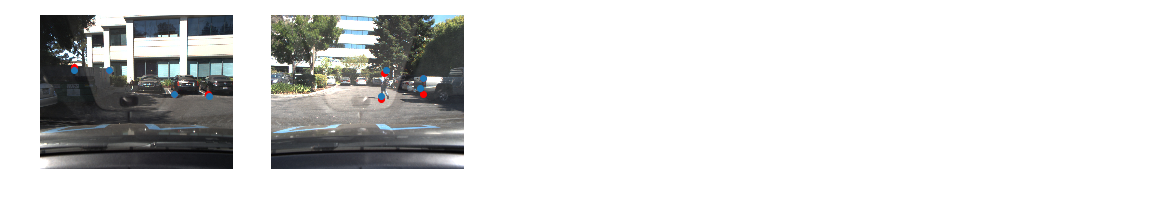

In [12]:
x = final_result.x
tx, ty, tz, yaw, pitch, roll = x
translation = [tx, ty, tz, 1]
rotationMatrix = tf.transformations.euler_matrix(roll, pitch, yaw)
rotationMatrix[:, 3] = translation
cameraModel.P = P0 * rotationMatrix * R0

fig, axes = plt.subplots(nrow, ncol, figsize=(20,3*nrow))
for ax in axes.flatten():
    ax.axis('off')

for frame, img_file, ax in zip(frame_list, images, axes.flatten()) :
    img = cv2.imread(img_file)
    img = BGR2RGB(img)
    ax.imshow(img)
    pts = np.array(frame['camera'])
    ax.scatter(pts.T[0], pts.T[1], c='red')
    ax.axis('off')
    pts_pred = []
    for pt_cloud, pt_cam in zip(frame['cloud'],frame['camera']) :
        pts_pred.append(cameraModel.project3dToPixel(pt_cloud+[1]))
    pts_pred = np.array(pts_pred)
    ax.scatter(pts_pred.T[0], pts_pred.T[1])

In [13]:
x = final_result.x
tx, ty, tz, yaw, pitch, roll = x
translation = [tx, ty, tz, 1]
rotationMatrix = tf.transformations.euler_matrix(roll, pitch, yaw)
rotationMatrix[:, 3] = translation
print("Final projection matrix : ")
print(P0*rotationMatrix*R0)

Final projection matrix : 
[[  4.49916663e+02  -1.42728805e+03   3.29382677e+01  -6.16834803e+02]
 [  4.95104096e+02  -1.20367191e+02  -1.39259049e+03  -2.04942282e+03]
 [  9.91568725e-01  -1.23156362e-01  -4.02985739e-02  -1.04467220e+00]]


** How to use projection matrix :  **

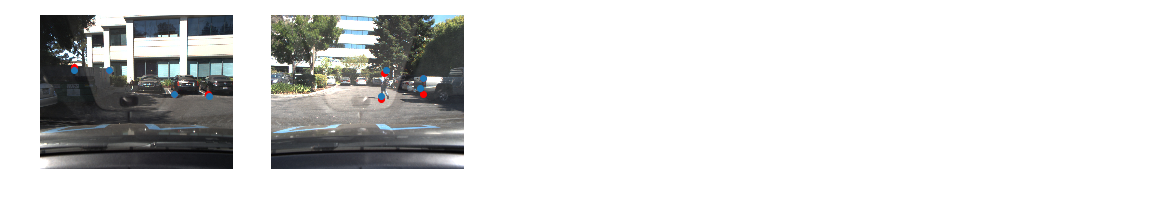

In [14]:
projMat = np.matrix([[  4.49926949e+02,  -1.42728451e+03,   3.29514692e+01, -6.17129423e+02],
                     [  4.95109204e+02,  -1.20375134e+02,  -1.39258798e+03, -2.04959403e+03],
                     [  9.91569743e-01,  -1.23149481e-01,  -4.02945398e-02, -1.04485078e+00]])

fig, axes = plt.subplots(nrow, ncol, figsize=(20,3*nrow))
for ax in axes.flatten():
    ax.axis('off')

for frame, img_file, ax in zip(frame_list, images, axes.flatten()) :
    img = cv2.imread(img_file)
    img = BGR2RGB(img)
    ax.imshow(img)
    pts = np.array(frame['camera'])
    ax.scatter(pts.T[0], pts.T[1], c='red')
    ax.axis('off')
    pts_pred = []
    for pt_cloud, pt_cam in zip(frame['cloud'],frame['camera']) :
        X = projMat*np.matrix(pt_cloud+[1]).T
        X = np.array(X[:2,0]/X[2,0]).flatten()
        pts_pred.append(X)
    pts_pred = np.array(pts_pred)
    ax.scatter(pts_pred.T[0], pts_pred.T[1])